In [38]:
include("DataManifest.jl")
using Revise
import .DataManifest

using JSON
using CSV
using Statistics
using DataFrames
using Plots
using StatsPlots
using StatsBase
using LaTeXStrings
using GLM
using Random
using Combinatorics
using Printf
using LinearAlgebra
#using Graphs
#using MetaGraphs
#using GraphPlot

In [94]:
ENV["LINES"]=200 

200

In [95]:
POSTER_FIGURES_PATH = "/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/Poster/figures"
PAPER_FIGURES_PATH = "/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/FinalPaper/figures"

"/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/FinalPaper/figures"

# Manifests

In [4]:
# manifest = DataManifest.build_manifest(
#     DataManifest.PropublicaManifestType,
#     true
# )

In [5]:
# open("/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/Data/Raw/ProPublicaBulkBills/manifest.json","w") do io
#     JSON.print(io, manifest)
# end

In [6]:
textManifest = DataManifest.load_manifest(DataManifest.TextManifestType)
proPublicaManifest = DataManifest.load_manifest(DataManifest.PropublicaManifestType)

Dict{String, Any} with 13 entries:
  "109" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "114" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "104" => Dict{String, Any}("hres"=>Dict{String, Any}("306"=>"/Users/alexray/D…
  "106" => Dict{String, Any}("hres"=>Dict{String, Any}("153"=>"/Users/alexray/D…
  "113" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "110" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "108" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "111" => Dict{String, Any}("hres"=>Dict{String, Any}("1766"=>"/Users/alexray/…
  "112" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "115" => Dict{String, Any}("hres"=>Dict{String, Any}("1"=>"/Users/alexray/Dro…
  "107" => Dict{String, Any}("hres"=>Dict{String, Any}("306"=>"/Users/alexray/D…
  "103" => Dict{String, Any}("hres"=>Dict{String, Any}("306"=>"/Users/alex

# Maybe Useful Utils

In [7]:
congress_to_start_year(congress) = congress + 1890 + (congress-103)
congress_to_start_year(congress::String) = parse(Int64, congress) + 1890 + (parse(Int64, congress)-103)

congress_to_start_year (generic function with 2 methods)

In [8]:
function get_bill_size(textManifest, cid)
    return filesize(textManifest[cid.congress][cid.legislation_type][cid.legislation_number])
end

get_bill_size (generic function with 1 method)

In [9]:
THOMAS_TO_BIOGUIDE = JSON.parsefile("/Users/alexray/Documents/data/legislators/bioguide_lookup")
BIOGUIDE_TO_META = JSON.parsefile("/Users/alexray/Documents/data/legislators/party_lookup")

Dict{String, Any} with 12293 entries:
  "B000442" => Dict{String, Any}("name"=>"Joseph Biddle", "party"=>"Republican"…
  "G000460" => Dict{String, Any}("name"=>"Daniel Griffin", "party"=>"Democrat",…
  "J000118" => Dict{String, Any}("name"=>"Ben Johnson", "party"=>"Democrat", "s…
  "M000170" => Dict{String, Any}("name"=>"Charles Martin", "party"=>"Democrat",…
  "D000016" => Dict{String, Any}("name"=>"John Dalzell", "party"=>"Republican",…
  "H000400" => Dict{String, Any}("name"=>"Martin Haynes", "party"=>"Republican"…
  "G000358" => Dict{String, Any}("name"=>"John Graham", "party"=>"Democrat", "s…
  "D000448" => Dict{String, Any}("name"=>"Robert Doughton", "party"=>"Democrat"…
  "B000350" => Dict{String, Any}("name"=>"Joseph Bellinger", "party"=>"Republic…
  "Q000023" => Dict{String, Any}("name"=>"Mike Quigley", "party"=>"Democrat", "…
  "H000079" => Dict{String, Any}("name"=>"William Hall", "party"=>"Democrat", "…
  "L000235" => Dict{String, Any}("name"=>"John Leisenring", "party"=>"R

In [110]:
CONGRESS_TO_PRESIDENT_PARTY = Dict(
    103 => "Democrat",
    104 => "Democrat",
    105 => "Democrat",
    106 => "Democrat",
    107 => "Republican",
    108 => "Republican",
    109 => "Republican",
    110 => "Republican",
    111 => "Democrat",
    112 => "Democrat",
    113 => "Democrat",
    114 => "Democrat",
    115 => "Republican"
)

Dict{Int64, String} with 13 entries:
  112 => "Democrat"
  114 => "Democrat"
  105 => "Democrat"
  110 => "Republican"
  107 => "Republican"
  108 => "Republican"
  103 => "Democrat"
  111 => "Democrat"
  113 => "Democrat"
  104 => "Democrat"
  115 => "Republican"
  106 => "Democrat"
  109 => "Republican"

In [120]:
function is_main_party(party)
    return if (party in ["Democrat", "Republican"])
        true
    else
        false
    end
end

function get_opposing_party(party)
    return if (party == "Democrat")
        "Republican"
    elseif (party == "Republican")
        "Democrat"
    else
        error("Found non-normal party $party") 
    end
end

get_opposing_party (generic function with 1 method)

# Legislation Dataframe

In [111]:
LEGISLATION_CSV_PATH = "/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/Data/Processed/legislation.csv"

function bioguide_from_info(info)
    return if (!haskey(info, "bioguide_id"))
        THOMAS_TO_BIOGUIDE[info["thomas_id"]]
    else
        info["bioguide_id"]
    end
end

function construct_legislation_dataframe()
    legislation = DataFrame(
        Congress = String[], 
        Id = String[],
        Type = String[],
        Number = String[],
        Size = Int64[],
        NumAmendments = Int64[],
        NumCosponsors = Int64[],
        NumSubjects = Int64[],
        Subjects = Array{String}[],
        SubjectsTopTerm = String[],
        SponsorId = String[],
        SponsorParty = String[],
        CosponsorIds = Array{String}[],
        AnyCosponsored = Int64[],
        DifferentPartyCosponsored = Int64[],
        NumDifferentPartyCosponsored = Int64[],
        SponsorMatchesPresidentParty = Int64[]
    )

    for congress in 103:115
        println(congress)
        president_party = CONGRESS_TO_PRESIDENT_PARTY[congress]
        for legislation_type in ["s"]
            legislation_info_paths = proPublicaManifest[string(congress)][legislation_type]
            for (num, info_path) in legislation_info_paths
                info = JSON.parsefile(info_path)
                
#                 sponsor_bioguide_id = if (!haskey(info["sponsor"], "bioguide_id"))
#                     THOMAS_TO_BIOGUIDE[info["sponsor"]["thomas_id"]]
#                 else
#                     info["sponsor"]["bioguide_id"]
#                 end
                sponsor_bioguide_id = bioguide_from_info(info["sponsor"])
                
                subjects_top_term = if (info["subjects_top_term"] == nothing)
                    ""
                else
                    info["subjects_top_term"]
                end
                
                sponsor_party = BIOGUIDE_TO_META[sponsor_bioguide_id]["party"]
            
                sponsor_matches_president_party = 0
                if (sponsor_party == president_party)
                    sponsor_matches_president_party = 1
                end
                
                any_cosponsorship = 0
                different_party_cosponsorship = 0
                num_different_party_cosponsorships = 0
                cosponsor_ids = []
                for cosponsor in info["cosponsors"]
                    any_cosponsorship = 1
                    cosponsor_bioguide_id = bioguide_from_info(cosponsor)
                    push!(cosponsor_ids, cosponsor_bioguide_id)
                    if (BIOGUIDE_TO_META[cosponsor_bioguide_id]["party"] != sponsor_party)
                        different_party_cosponsorship = 1
                        num_different_party_cosponsorships += 1
                    end
                end
                
                try
                    push!(
                        legislation, 
                        Dict(
                            :Congress => string(congress), 
                            :Id => info["bill_id"],
                            :Type => legislation_type,
                            :Number => num,
                            :Size => filesize(textManifest[string(congress)][legislation_type][num]),
                            :NumAmendments => length(info["amendments"]),
                            :NumCosponsors => length(info["cosponsors"]),
                            :NumSubjects => length(info["subjects"]),
                            :Subjects => info["subjects"],
                            :SubjectsTopTerm => subjects_top_term,
                            :SponsorId => sponsor_bioguide_id,
                            :SponsorParty => sponsor_party,
                            :CosponsorIds => cosponsor_ids,
                            :AnyCosponsored => any_cosponsorship,
                            :DifferentPartyCosponsored => different_party_cosponsorship,
                            :NumDifferentPartyCosponsored => num_different_party_cosponsorships,
                            :SponsorMatchesPresidentParty => sponsor_matches_president_party
                        )
                    )
                catch e
                    if isa(e, KeyError)
                        println(e)
                    else
                        rethrow(e)
                    end
                end

            end
        end
    end
    
    return legislation
end

legislation = if (false && isfile(LEGISLATION_CSV_PATH)) 
    DataFrame(CSV.File(LEGISLATION_CSV_PATH))
else 
    df = construct_legislation_dataframe()
    open(LEGISLATION_CSV_PATH,"w") do io
        CSV.write(io, df)
    end
    df
end

103
104
KeyError("1795")
105
106
KeyError("2545")
KeyError("3126")
107
108
109
110
111
112
113
114
115


42933×17 DataFrame
   Row │ Congress  Id         Type    Number  Size    NumAmendments  NumCospon ⋯
       │ String    String     String  String  Int64   Int64          Int64     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ 103       s1766-103  s       1766      5616              0            ⋯
     2 │ 103       s1886-103  s       1886      2224              0
     3 │ 103       s1-103     s       1       294700             15
     4 │ 103       s519-103   s       519       2788              0
     5 │ 103       s2243-103  s       2243      9095              1            ⋯
     6 │ 103       s788-103   s       788       1524              0
     7 │ 103       s1164-103  s       1164      3199              0
     8 │ 103       s2489-103  s       2489     38289              0
     9 │ 103       s774-103   s       774       7447              0            ⋯
    10 │ 103       s1881-103  s       1881     30566              0
    11 │ 103       s1907-103  s       1907      3174              0
    12 │ 103       s2504-103  s       2504     58541              0
    13 │ 103       s2057-103  s       2057     29419              0            ⋯
    14 │ 103       s2491-103  s       2491     52744              0
    15 │ 103       s491-103   s       491     288295              1
    16 │ 103       s599-103   s       599       2344              0
    17 │ 103       s1195-103  s       1195     45401              0            ⋯
    18 │ 103       s1470-103  s       1470      2904              0
    19 │ 103       s1377-103  s       1377      1527              0
    20 │ 103       s228-103   s       228       7605              0
    21 │ 103       s332-103   s       332      18574              0            ⋯
    22 │ 103       s190-103   s       190       2653              0
    23 │ 103       s227-103   s       227       1667              0
    24 │ 103       s980-103   s       980      48125              0
    25 │ 103       s1935-103  s       1935     46793             11            ⋯
    26 │ 103       s1894-103  s       1894      3297              0
    27 │ 103       s2472-103  s       2472      8104              0
    28 │ 103       s1305-103  s       1305      2353              0
    29 │ 103       s1880-103  s       1880      1418              0            ⋯
    30 │ 103       s2562-103  s       2562      5683              0
    31 │ 103       s297-103   s       297       4638              0
    32 │ 103       s605-103   s       605       5545              0
    33 │ 103       s2078-103  s       2078      2738              0            ⋯
    34 │ 103       s2394-103  s       2394     13399              0
    35 │ 103       s1106-103  s       1106      3448              0
    36 │ 103       s2366-103  s       2366      1944              0
    37 │ 103       s24-103    s       24       22286             10            ⋯
    38 │ 103       s1783-103  s       1783      2386              0
    39 │ 103       s928-103   s       928       5668              0
    40 │ 103       s204-103   s       204       2827              0
    41 │ 103       s1863-103  s       1863     22090              0            ⋯
    42 │ 103       s23-103    s       23        1335              0
    43 │ 103       s160-103   s       160      25240              0
    44 │ 103       s1825-103  s       1825     15387              0
    45 │ 103       s416-103   s       416       4312              0            ⋯
    46 │ 103       s1941-103  s       1941      1523              0
    47 │ 103       s561-103   s       561      19950              0
    48 │ 103       s859-103   s       859       2625              0
    49 │ 103       s2527-103  s       2527      1716              0            ⋯
    50 │ 103       s891-103   s       891      51090              0
    51 │ 103       s2208-103  s       2208    505498              0
    52 │ 103       s1879-103  s       1879      2598              0
    53 │ 103       s815-103   s  

# Legislator Dataframe
Note that this relies on a legislator to have sponsored or cosponsored at least one thing

In [11]:
LEGISLATORS_CSV_PATH = "/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/Data/Processed/legislators.csv"


function construct_legislators_dataframe()
    s = Set()
    legislators = DataFrame(
        BioguideId = String[],
        Party = String[],
        Name = String[],
        State = String[]
    )

    for congress in 103:115
        println(congress)
        for legislation_type in ["s"]
            legislation_info_paths = proPublicaManifest[string(congress)][legislation_type]
            for (num, info_path) in legislation_info_paths
                info = JSON.parsefile(info_path)
                
                sponsor_bioguide_id = bioguide_from_info(info["sponsor"])
                push!(s, sponsor_bioguide_id)
                
                for cosponsor in info["cosponsors"]
                    push!(s, bioguide_from_info(cosponsor))
                end
                
            end
        end
    end
    
    for id in s
        info = BIOGUIDE_TO_META[id]
        push!(
            legislators, 
            Dict(
                :BioguideId => id, 
                :Party => info["party"],
                :Name => info["name"],
                :State => info["state"]
            )
        )
    end
    
    return legislators
end

legislators = if (isfile(LEGISLATORS_CSV_PATH)) 
    DataFrame(CSV.File(LEGISLATORS_CSV_PATH))
else 
    df = construct_legislators_dataframe()
    open(LEGISLATORS_CSV_PATH,"w") do io
        CSV.write(io, df)
    end
    df
end



260×4 DataFrame
 Row │ BioguideId  Party        Name                    State   
     │ String7     String15     String31                String3 
─────┼──────────────────────────────────────────────────────────
   1 │ C000560     Republican   Thomas Coburn           OK
   2 │ N000180     Democrat     Ben Nelson              NE
   3 │ P000590     Democrat     Mark Pryor              AR
   4 │ W000779     Democrat     Ron Wyden               OR
   5 │ S001163     Democrat     Ken Salazar             CO
   6 │ P000556     Democrat     David Pryor             AR
   7 │ S000663     Republican   Olympia Snowe           ME
   8 │ B001126     Republican   Conrad Burns            MT
   9 │ C000269     Republican   John Chafee             RI
  10 │ A000069     Democrat     Daniel Akaka            HI
  11 │ B001267     Democrat     Michael Bennet          CO
  12 │ C000542     Republican   Daniel Coats            IN
  13 │ N000171     Democrat     Samuel Nunn             GA
  14 │ C001099     Democrat     William Cowan           MA
  15 │ M001162     Republican   Mel Martinez            FL
  16 │ C001043     Democrat     Jean Carnahan           MO
  17 │ S000888     Republican   Ted Stevens             AK
  18 │ C000813     Republican   Paul Coverdell          GA
  19 │ S001078     Republican   John Sununu             NH
  20 │ H001075     Democrat     Kamala Harris           CA
  21 │ B001277     Democrat     Richard Blumenthal      CT
  22 │ H001042     Democrat     Mazie Hirono            HI
  23 │ B001135     Republican   Richard Burr            NC
  24 │ K000373     Democrat     Edward Kaufman          DE
  25 │ R000249     Republican   Donald Riegle           MI
  26 │ N000102     Republican   Don Nickles             OK
  27 │ M000133     Democrat     Edward Markey           MA
  28 │ U000038     Democrat     Mark Udall              CO
  29 │ R000584     Republican   James Risch             ID
  30 │ W000092     Republican   Malcolm Wallop          WY
  31 │ P000603     Republican   Rand Paul               KY
  32 │ L000447     Republican   Trent Lott              MS
  33 │ S000148     Democrat     Charles Schumer         NY
  34 │ D000185     Democrat     Dennis DeConcini        AZ
  35 │ P000513     Republican   Larry Pressler          SD
  36 │ J000177     Democrat     Tim Johnson             SD
  37 │ B000444     Democrat     Joseph Biden            DE
  38 │ D000563     Democrat     Richard Durbin          IL
  39 │ H001041     Republican   Dean Heller             NV
  40 │ L000174     Democrat     Patrick Leahy           VT
  41 │ A000121     Republican   George Allen            VA
  42 │ T000464     Democrat     Jon Tester              MT
  43 │ I000024     Republican   James Inhofe            OK
  44 │ H000445     Democrat     Howell Heflin           AL
  45 │ K000305     Democrat     Herbert Kohl            WI
  46 │ H001015     Republican   Tim Hutchinson          AR
  47 │ C001070     Democrat     Robert Casey            PA
  48 │ R000146     Democrat     Harry Reid              NV
  49 │ S001181     Democrat     Jeanne Shaheen          NH
  50 │ S000423     Democrat     Paul Simon              IL
  51 │ S000709     Republican   Arlen Specter           PA
  52 │ B001230     Democrat     Tammy Baldwin           WI
  53 │ B000575     Republican   Roy Blunt               MO
  54 │ G000562     Republican   Cory Gardner            CO
  55 │ M000355     Republican   Mitch McConnell         KY
  56 │ R000361     Democrat     John Rockefeller        WV
  57 │ S001203     Democrat     Tina Smith              MN
  58 │ M001111     Democrat     Patty Murray            WA
  59 │ U000039     Democrat     Tom Udall               NM
  60 │ A000368     Republican   Kelly Ayotte            NH
  61 │ G000386     Republican   Charles Grassley        IA
  62 │ C001041     Democrat     Hillary Clinton         NY
  63 │ B001225     Democrat     William Bradley         NJ
  64 │ L000550     Democrat     Mary Landrieu           LA
  65 │ G00056

# Legislation-Cosponsor Dataframe
Note that rows with blank cosponsors will be included s/t legislation with no cosponsors is included

In [12]:
LEGISLATION_COSPONSOR_CSV_PATH = "/Users/alexray/Dropbox/PhD/Courses/Fall21/PSCI7075/Project/Data/Processed/legislation_cosponsor.csv"


function construct_legislation_cosponsor_dataframe()
    legislation_cosponsor = DataFrame(
        LegislationId = String[],
        SponsorId = String[],
        CosponsorId = Union{Missing,String}[]
    )

    for congress in 103:115
        println(congress)
        for legislation_type in ["s"]
            legislation_info_paths = proPublicaManifest[string(congress)][legislation_type]
            for (num, info_path) in legislation_info_paths
                info = JSON.parsefile(info_path)
                
                sponsor_bioguide_id = bioguide_from_info(info["sponsor"])
                
                push!(
                    legislation_cosponsor, 
                    Dict(
                        :LegislationId => info["bill_id"], 
                        :SponsorId => sponsor_bioguide_id,
                        :CosponsorId => missing
                    )
                )
                
                for cosponsor in info["cosponsors"]
                    push!(
                        legislation_cosponsor, 
                        Dict(
                            :LegislationId => info["bill_id"], 
                            :SponsorId => sponsor_bioguide_id,
                            :CosponsorId => bioguide_from_info(cosponsor)
                        )
                    )
                end
                
            end
        end
    end
    
    return legislation_cosponsor
end

legislation_cosponsor = if (isfile(LEGISLATION_COSPONSOR_CSV_PATH)) 
    DataFrame(CSV.File(LEGISLATION_COSPONSOR_CSV_PATH))
else 
    df = construct_legislation_cosponsor_dataframe()
    open(LEGISLATION_COSPONSOR_CSV_PATH,"w") do io
        CSV.write(io, df)
    end
    df
end

253282×3 DataFrame
    Row │ LegislationId  SponsorId  CosponsorId 
        │ String15       String7    String7?    
────────┼───────────────────────────────────────
      1 │ s1766-103      G000352    missing     
      2 │ s1766-103      G000352    M000019
      3 │ s1886-103      W000154    missing     
      4 │ s1886-103      W000154    R000295
      5 │ s1-103         K000105    missing     
      6 │ s1-103         K000105    B000711
      7 │ s1-103         K000105    D000388
      8 │ s1-103         K000105    D000566
      9 │ s1-103         K000105    H000206
     10 │ s1-103         K000105    H000338
     11 │ s1-103         K000105    I000025
     12 │ s1-103         K000105    K000017
     13 │ s1-103         K000105    K000148
     14 │ s1-103         K000105    L000123
     15 │ s1-103         K000105    L000174
     16 │ s1-103         K000105    L000261
     17 │ s1-103         K000105    M000678
     18 │ s1-103         K000105    M000702
     19 │ s1-103         K000105    M001025
     20 │ s1-103         K000105    P000193
     21 │ s1-103         K000105    R000249
     22 │ s1-103         K000105    R000361
     23 │ s1-103         K000105    S000064
     24 │ s1-103         K000105    S000423
     25 │ s1-103         K000105    W000288
     26 │ s1-103         K000105    W000665
     27 │ s519-103       B001057    missing     
     28 │ s519-103       B001057    B000993
     29 │ s519-103       B001057    C000705
     30 │ s519-103       B001057    D000064
     31 │ s519-103       B001057    D000185
     32 │ s519-103       B001057    D000432
     33 │ s519-103       B001057    F000061
     34 │ s519-103       B001057    H000206
     35 │ s519-103       B001057    J000072
     36 │ s519-103       B001057    K000305
     37 │ s519-103       B001057    L000123
     38 │ s519-103       B001057    S000068
     39 │ s519-103       B001057    W000665
     40 │ s2243-103      S000888    missing     
     41 │ s2243-103      S000888    C000858
     42 │ s2243-103      S000888    G000333
     43 │ s2243-103      S000888    H000343
     44 │ s2243-103      S000888    M001085
     45 │ s2243-103      S000888    M001111
     46 │ s2243-103      S000888    P000009
     47 │ s788-103       I000025    missing     
     48 │ s788-103       I000025    A000069
     49 │ s1164-103      M000019    missing     
     50 │ s2489-103      K000105    missing     
     51 │ s2489-103      K000105    A000069
     52 │ s2489-103      K000105    B000444
     53 │ s2489-103      K000105    B000468
     54 │ s2489-103      K000105    B000639
     55 │ s2489-103      K000105    B000711
     56 │ s2489-103      K000105    B001225
     57 │ s2489-103      K000105    B000780
     58 │ s2489-103      K000105    B000993
     59 │ s2489-103      K000105    B001057
     60 │ s2489-103      K000105    C000077
     61 │ s2489-103      K000105    C000269
     62 │ s2489-103      K000105    C000598
     63 │ s2489-103      K000105    C000705
     64 │ s2489-103      K000105    D000018
     65 │ s2489-103      K000105    D000064
     66 │ s2489-103      K000105    D000185
     67 │ s2489-103      K000105    D000388
     68 │ s2489-103      K000105    D000432
     69 │ s2489-103      K000105    D000566
     70 │ s2489-103      K000105    F000061
     71 │ s2489-103      K000105    F000062
     72 │ s2489-103      K000105    F000268
     73 │ s2489-103      K000105    G000236
     74 │ s2489-103      K000105    G000352
     75 │ s2489-103      K000105    H000206
     76 │ s2489-103      K000105    H000338
     77 │ s2489-103      K000105    H000343
     78 │ s2489-103      K000105    H000725
     79 │ s2489-103      K000105    H001016
     80 │ s2489-103      K000105    I000025
     81 │ s2489-103      K000105    J000072
     82 │ s2489-103      K000105    J000189
     83 │ s2489-103      K000105    K000146
     84 │ s2489-103      K000105    K000148
     85 │ s2489-103      K000105    K000305
     86 │ s2489-103      K000105    L000123
     87 │ 

# Legislation Analysis

In [112]:
grouped_legislation = groupby(legislation, :Congress)
#legislation_with_cosponsor = filter(row -> row.NumCosponsors > 0, legislation)
#legislation_with_top_subject = filter(row -> row.SubjectsTopTerm != "", legislation)

GroupedDataFrame with 13 groups based on key: Congress
First Group (2569 rows): Congress = "103"
  Row │ Congress  Id         Type    Number  Size    NumAmendments  NumCospons ⋯
      │ String    String     String  String  Int64   Int64          Int64      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 103       s1766-103  s       1766      5616              0             ⋯
    2 │ 103       s1886-103  s       1886      2224              0
    3 │ 103       s1-103     s       1       294700             15
    4 │ 103       s519-103   s       519       2788              0
    5 │ 103       s2243-103  s       2243      9095              1             ⋯
    6 │ 103       s788-103   s       788       1524              0
    7 │ 103       s1164-103  s       1164      3199              0
    8 │ 103       s2489-103  s       2489     38289              0
    9 │ 103       s774-103   s       774       7447              0             ⋯
   10 │ 103       s1881-103  s       1881     30566              0
   11 │ 103       s1907-103  s       1907      3174              0
   12 │ 103       s2504-103  s       2504     58541              0
   13 │ 103       s2057-103  s       2057     29419              0             ⋯
   14 │ 103       s2491-103  s       2491     52744              0
   15 │ 103       s491-103   s       491     288295              1
   16 │ 103       s599-103   s       599       2344              0
   17 │ 103       s1195-103  s       1195     45401              0             ⋯
   18 │ 103       s1470-103  s       1470      2904              0
   19 │ 103       s1377-103  s       1377      1527              0
   20 │ 103       s228-103   s       228       7605              0
   21 │ 103       s332-103   s       332      18574              0             ⋯
   22 │ 103       s190-103   s       190       2653              0
   23 │ 103       s227-103   s       227       1667              0
   24 │ 103       s980-103   s       980      48125              0
   25 │ 103       s1935-103  s       1935     46793             11             ⋯
   26 │ 103       s1894-103  s       1894      3297              0
   27 │ 103       s2472-103  s       2472      8104              0
   28 │ 103       s1305-103  s       1305      2353              0
   29 │ 103       s1880-103  s       1880      1418              0             ⋯
   30 │ 103       s2562-103  s       2562      5683              0
   31 │ 103       s297-103   s       297       4638              0
   32 │ 103       s605-103   s       605       5545              0
   33 │ 103       s2078-103  s       2078      2738              0             ⋯
   34 │ 103       s2394-103  s       2394     13399              0
   35 │ 103       s1106-103  s       1106      3448              0
   36 │ 103       s2366-103  s       2366      1944              0
   37 │ 103       s24-103    s       24       22286             10             ⋯
   38 │ 103       s1783-103  s       1783      2386              0
   39 │ 103       s928-103   s       928       5668              0
   40 │ 103       s204-103   s       204       2827              0
   41 │ 103       s1863-103  s       1863     22090              0             ⋯
   42 │ 103       s23-103    s       23        1335              0
   43 │ 103       s160-103   s       160      25240              0
   44 │ 103       s1825-103  s       1825     15387              0
   45 │ 103       s416-103   s       416       4312              0             ⋯
   46 │ 103       s1941-103  s       1941      1523              0
   47 │ 103       s561-103   s       561      19950              0
   48 │ 103       s859-103   s       859       2625              0
   49 │ 103       s2527-103  s       2527      1716              0             ⋯
   50 │ 103       s891-103   s       891      51090              0
   51 │ 103       s2208-103  s       2208    505498              0
   52 │ 103       s1879-103  s       1879      2598          

## Leg Summary Table

In [69]:
df = filter(row -> is_main_party(row.SponsorParty), legislation)

df = combine(
    groupby(df, :Congress), 
    nrow => :num_bills,
    :NumCosponsors => mean => :avg_cosponsors,
    :NumDifferentPartyCosponsored => mean => :avg_diff_party_cosponsors,
    :NumSubjects => mean => :avg_subjects,
    :Size => mean => :avg_size
)
df = transform(df, :Congress => ByRow(x -> congress_to_start_year(x)) => :start_year)

println()
for r in eachrow(df)
    println("$(r.Congress) & $(r.start_year) & $(r.num_bills) & $(@sprintf("%.2f", r.avg_cosponsors)) & $(@sprintf("%.2f", r.avg_diff_party_cosponsors)) & $(ceil(Int, r.avg_size)) & $(ceil(Int, r.avg_subjects)) \\\\")
end

42659

103 & 1993 & 2569 & 4.41 & 1.51 & 32881 & 22 \\
104 & 1995 & 2198 & 4.10 & 1.41 & 30607 & 28 \\
105 & 1997 & 2655 & 4.58 & 1.69 & 25441 & 30 \\
106 & 1999 & 3285 & 5.41 & 2.00 & 24222 & 27 \\
107 & 2001 & 3180 & 4.92 & 1.85 & 23888 & 28 \\
108 & 2003 & 3035 & 5.28 & 1.98 & 28737 & 28 \\
109 & 2005 & 4122 & 4.16 & 1.50 & 22799 & 21 \\
110 & 2007 & 3716 & 5.50 & 1.86 & 26688 & 21 \\
111 & 2009 & 4019 & 4.10 & 1.16 & 22785 & 8 \\
112 & 2011 & 3688 & 4.36 & 1.07 & 20219 & 9 \\
113 & 2013 & 2944 & 5.83 & 1.53 & 25173 & 11 \\
114 & 2015 & 3495 & 5.33 & 1.54 & 24458 & 11 \\
115 & 2017 & 3753 & 5.66 & 1.74 & 21498 & 9 \\


In [68]:
df = filter(row -> is_main_party(row.SponsorParty), legislation)

df = combine(
    df,
    nrow => :num_bills,
    :NumCosponsors => mean => :avg_cosponsors,
    :NumDifferentPartyCosponsored => mean => :avg_diff_party_cosponsors,
    :NumSubjects => mean => :avg_subjects,
    :Size => mean => :avg_size
)

r = df[1, :]
println("$(r.num_bills) & $(@sprintf("%.2f", r.avg_cosponsors)) & $(@sprintf("%.2f", r.avg_diff_party_cosponsors)) & $(ceil(Int, r.avg_size)) & $(ceil(Int, r.avg_subjects)) \\\\")


42659 & 4.90 & 1.59 & 24886 & 19 \\


## Bills over time

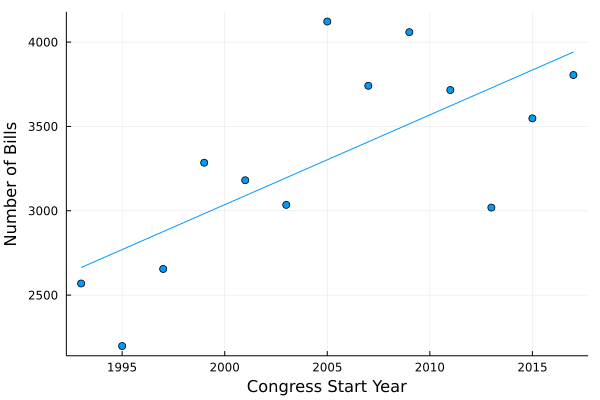

In [149]:
df = combine(grouped_legislation, nrow => :Count)
@df df plot(
    map(x -> congress_to_start_year(parse(Int, x)), :Congress),
    :Count,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Number of Bills"
)

## Bills with any cosponsors over time

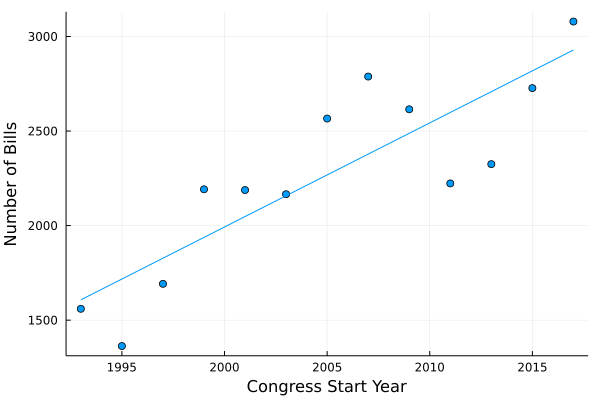

In [150]:
df = filter(x->x.AnyCosponsored > 0, legislation)
df = combine(groupby(df, :Congress), nrow => :Count)
@df df plot(
    map(x -> congress_to_start_year(parse(Int, x)), :Congress),
    :Count,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Number of Bills"
)

## Legislation size over time

In [145]:
df = combine(grouped_legislation, :Size => mean)
@df df plot(
    map(x -> congress_to_start_year(x), :Congress),
    :Size_mean,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Average Legislation Size (bytes)"
)
savefig("$FIGURES_PATH/legislation_size_over_time.png")

## Number of subjects over time

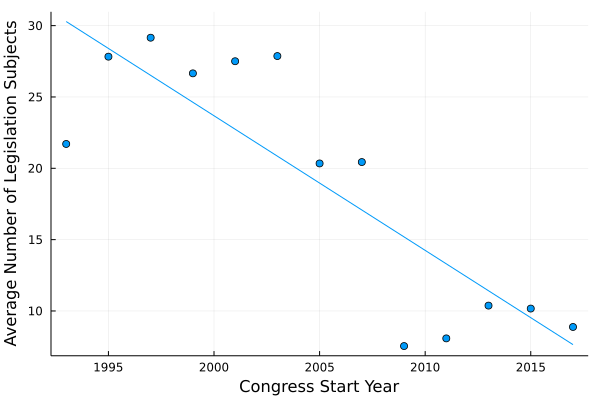

In [145]:
df = combine(grouped_legislation, :NumSubjects => mean)
@df df plot(
    map(x -> congress_to_start_year(x), :Congress),
    :NumSubjects_mean,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Average Number of Legislation Subjects"
)

## Number of cosponsors over time

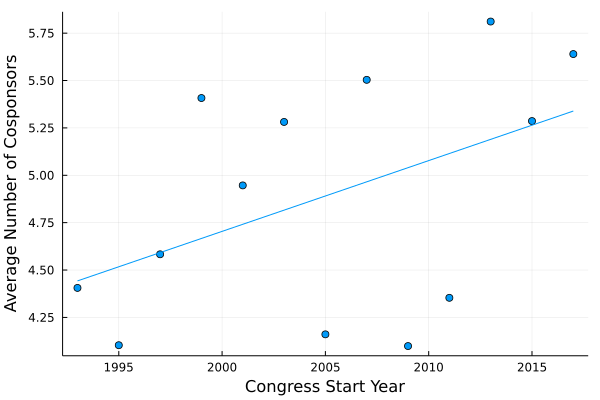

In [144]:
df = combine(grouped_legislation, :NumCosponsors => mean)
@df df plot(
    map(x -> congress_to_start_year(x), :Congress),
    :NumCosponsors_mean,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Average Number of Cosponsors"
)

## Number of different party cosponsors over time

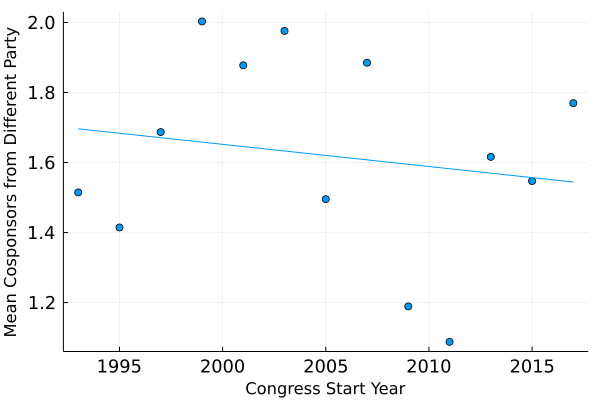

In [14]:
df = combine(grouped_legislation, :NumDifferentPartyCosponsored => mean)

@df df plot(
    map(x -> congress_to_start_year(x), :Congress),
    :NumDifferentPartyCosponsored_mean,
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Mean Cosponsors from Different Party",
    xtickfontsize = 12,
    ytickfontsize = 12,
)
#savefig("$FIGURES_PATH/different_party_cosponsors_over_time.png")

# Num diff party cosponsors/cosponsors over time

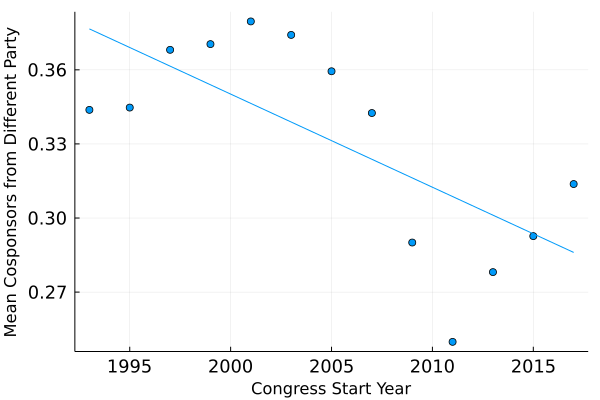

In [23]:
df = combine(grouped_legislation, :NumCosponsors => mean, :NumDifferentPartyCosponsored => mean)


@df df plot(
    map(x -> congress_to_start_year(x), :Congress),
    map((x) -> x[2]/x[1], zip(:NumCosponsors_mean, :NumDifferentPartyCosponsored_mean)),
    seriestype=:scatter,
    smooth=true,
    legend=false,
    xlabel="Congress Start Year",
    ylabel="Mean Cosponsors from Different Party",
    xtickfontsize = 12,
    ytickfontsize = 12,
)

## Overall cosponsor distribution

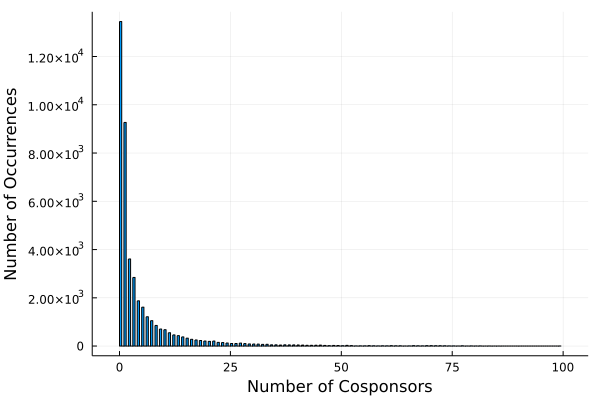

In [151]:
@df legislation plot(
    :NumCosponsors,
    seriestype=:histogram,
    legend=false,
    ylabel="Number of Occurrences",
    xlabel="Number of Cosponsors"
)

## Different party cosponsor distribution

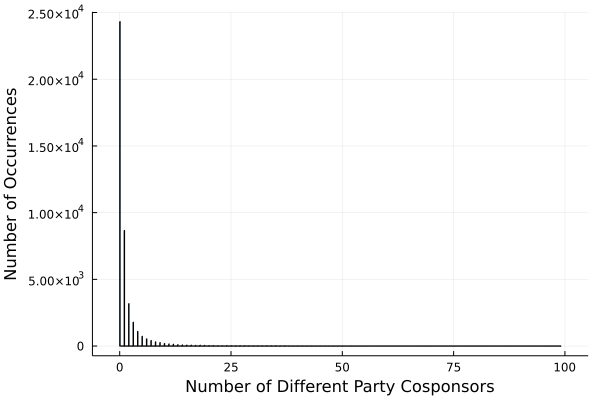

In [54]:
@df legislation plot(
    :NumDifferentPartyCosponsored,
    seriestype=:histogram,
    legend=false,
    ylabel="Number of Occurrences",
    xlabel="Number of Different Party Cosponsors"
)

# Overall subjects distribution

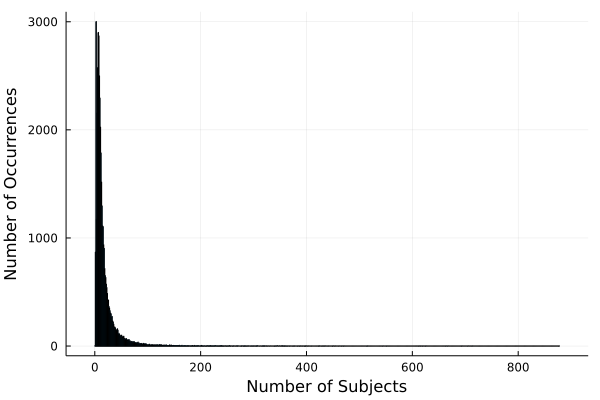

In [153]:
@df legislation plot(
    :NumSubjects,
    seriestype=:histogram,
    legend=false,
    ylabel="Number of Occurrences",
    xlabel="Number of Subjects"
)

# Overall size distribution

6705.0
17944.0
88168.20000000024
6705.0


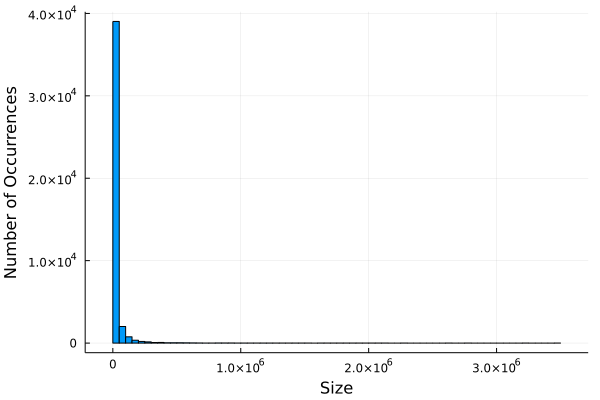

In [126]:
println(percentile(legislation.Size, 50))
println(percentile(legislation.Size, 75))
println(percentile(legislation.Size, 95))
println(median(legislation.Size))

#p = percentile(legislation.Size, 95)
plot(
    #filter(x -> x < p, legislation.Size),
    legislation.Size,
    seriestype=:histogram,
    legend=false,
    ylabel="Number of Occurrences",
    xlabel="Size",
    bins=100
)



1341.0
3588.8
17633.64000000005
1341.0


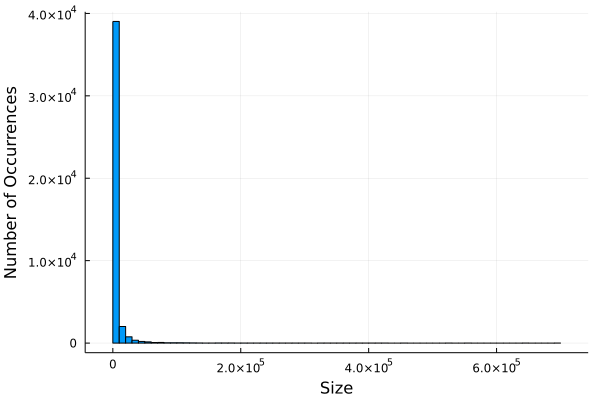

In [128]:
wc = map(x -> x/5, legislation.Size)
println(percentile(wc, 50))
println(percentile(wc, 75))
println(percentile(wc, 95))
println(median(wc))

plot(
    #filter(x -> x < p, legislation.Size),
    wc,
    seriestype=:histogram,
    legend=false,
    ylabel="Number of Occurrences",
    xlabel="Size",
    bins=100
)

## Relationship between number of subjects and size

In [56]:
lm1 = fit(LinearModel, @formula(Size ~ NumSubjects), legislation)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Size ~ 1 + NumSubjects

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -7137.84    400.867   -17.81    <1e-69   -7923.54   -6352.13
NumSubjects   1773.6      11.4623  154.73    <1e-99    1751.13    1796.07
─────────────────────────────────────────────────────────────────────────

## Relationship between number of cosponsors and number of subjects

In [113]:
lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsored ~ NumSubjects), legislation)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

NumDifferentPartyCosponsored ~ 1 + NumSubjects

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  1.50842     0.0233621   64.57    <1e-99  1.46263     1.55421
NumSubjects  0.00573803  0.00066801   8.59    <1e-17  0.00442872  0.00704735
────────────────────────────────────────────────────────────────────────────

## Relationship between number of cosponsors and size

In [142]:
lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsored ~ Size), legislation)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

NumDifferentPartyCosponsored ~ 1 + Size

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  1.59018     0.0207876   76.50    <1e-99  1.54943     1.63092
Size         8.81277e-7  2.25518e-7   3.91    <1e-04  4.39258e-7  1.3233e-6
───────────────────────────────────────────────────────────────────────────

In [143]:
r2(lm1)

0.00035558042391481415

## Relationship between a bunch of things and num different party cosponsors

In [101]:
lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsored ~ Congress + SponsorId + SubjectsTopTerm + Size), legislation)
#lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsored ~ Congress), legislation)



StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

NumDifferentPartyCosponsored ~ 1 + Congress + SponsorId + SubjectsTopTerm + Size

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                    Coef.    Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                                   -3.41269       0.991268     -3.44    0.0006   -5.35559      -1.46978
Congress                                                       0.042218      0.00898772    4.70    <1e-05    0.0246019     0.0598341
SponsorId: A000109                                             0.753444   

In [102]:
r2(lm1)

0.08907399357053092

In [107]:
Set(legislation.SponsorParty)

Set{String15} with 3 elements:
  "Republican"
  "Democrat"
  "Independent"

In [115]:
lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsored ~ SponsorMatchesPresidentParty + SubjectsTopTerm), legislation)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

NumDifferentPartyCosponsored ~ 1 + SponsorMatchesPresidentParty + SubjectsTopTerm

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                   Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                                    0.101618    0.605079    0.17    0.8666  -1.08435      1.28758
SponsorMatchesPresidentParty                                   0.0213586   0.0393852   0.54    0.5876  -0.0558372    0.0985543
SubjectsTopTerm: Abortion                                      0.371999    1.04001     0.36    0.7206  -1.

In [116]:
r2(lm1)

0.04596908020821566

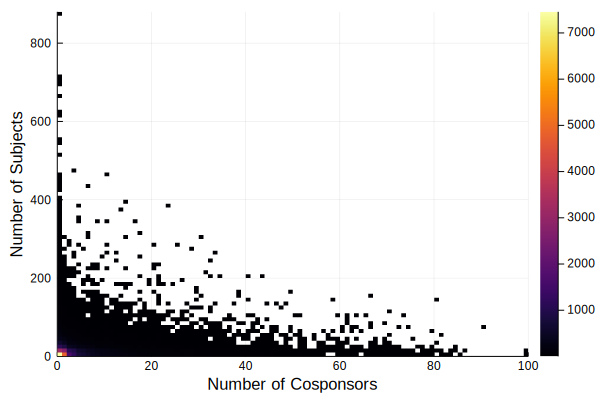

In [70]:
@df legislation plot(
    :NumCosponsors,
    :NumSubjects,
    seriestype=:histogram2d,
    bins=100,
    xlabel="Number of Cosponsors",
    ylabel="Number of Subjects"
)

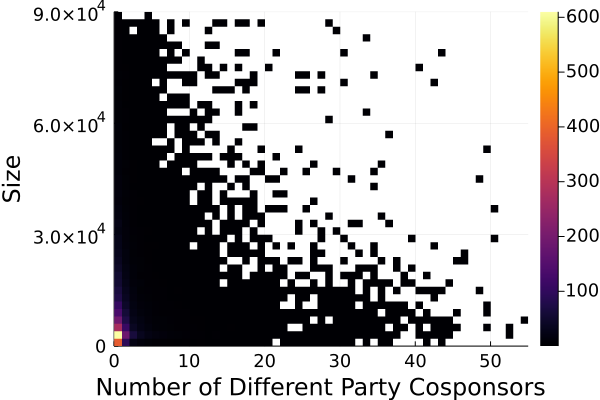

In [234]:
p = percentile(legislation.Size, 95)
df = filter(x -> x.Size < p && x.NumDifferentPartyCosponsored < 99 && x.NumDifferentPartyCosponsored >= 0, legislation)

@df df plot(
    :NumDifferentPartyCosponsored,
    :Size,
    seriestype=:histogram2d,
    bins=70,
    #yscale=:log10,
    xlabel="Number of Different Party Cosponsors",
    ylabel="Size",
    xguidefontsize = 16,
    yguidefontsize = 16,
    xtickfontsize = 12,
    ytickfontsize = 12
)
#savefig("~/Downloads/test.png")

## Legislation by Top Subject

In [110]:
df = combine(
    groupby(
        filter(x->x.NumDifferentPartyCosponsored > 0, legislation), 
        :SubjectsTopTerm
    ), 
    nrow => :Count, 
    :NumCosponsors => mean => :MeanCosponsors
)

sort!(df, :Count, rev=true)
# @df df plot(
#     :SubjectsTopTerm,
#     :Count,
#     seriestype=:bar,
# #     xlabel="Number of Cosponsors",
# #     ylabel="Number of Subjects"
# )

122×3 DataFrame
 Row │ SubjectsTopTerm                    Count  MeanCosponsors 
     │ String                             Int64  Float64        
─────┼──────────────────────────────────────────────────────────
   1 │ Health                              2521        11.0159
   2 │ Taxation                            1941         9.36218
   3 │ Armed forces and national securi…   1323         9.90703
   4 │ Crime and law enforcement           1068        10.0534
   5 │ Government operations and politi…    924         8.30519
   6 │ Public lands and natural resourc…    896         5.38058
   7 │ International affairs                739        12.0365
   8 │ Foreign trade and international …    698         4.97135
   9 │ Transportation and public works      672         7.06696
  10 │ Finance and financial sector         545         9.62018
  11 │ Environmental protection             531         8.85122
  ⋮  │                 ⋮                    ⋮          ⋮
 113 │ Claims                                 1        12.0
 114 │ Postal service                         1         3.0
 115 │ Special days                           1        10.0
 116 │ Industry                               1         9.0
 117 │ Corporations                           1         5.0
 118 │ Independent regulatory commissio…      1         5.0
 119 │ Public debt                            1         3.0
 120 │ Senate                                 1         8.0
 121 │ Emblems                                1         3.0
 122 │ Urban affairs                          1         1.0
                                                101 rows omitted

# Cosponsorship by legislator

In [173]:


df = innerjoin(legislation_cosponsor, legislation, on=[:LegislationId => :Id], makeunique=true)
df = dropmissing(df)
df = innerjoin(df, legislators, on=[:SponsorId => :BioguideId], renamecols = "" => "_sponsor")
df = innerjoin(df, legislators, on=[:CosponsorId => :BioguideId], renamecols = "" => "_cosponsor")

df = groupby(df, :Congress)

diff_party_cosponsorship_samples = []
for congress in 103:115
    group = df[(Congress = string(congress),)]
    diff_party_cosponsorships = []
    
    cosponsor_groups = groupby(group, :CosponsorId)
    
    for cosponsor in cosponsor_groups
        tmp = combine(cosponsor, [:Party_sponsor, :Party_cosponsor] => ByRow((ps, pcs) -> if (ps==pcs) 0 else 1 end) => :NumDifferentPartyCosponsorships)
        tmp = combine(tmp, :NumDifferentPartyCosponsorships => sum)
        push!(diff_party_cosponsorships, first(tmp).NumDifferentPartyCosponsorships_sum)
    end
    
    push!(diff_party_cosponsorship_samples, diff_party_cosponsorships)
end

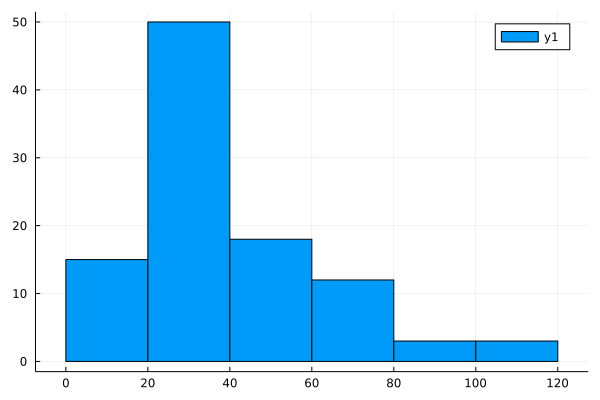

In [175]:
plot(first(diff_party_cosponsorship_samples), seriestype=:histogram)

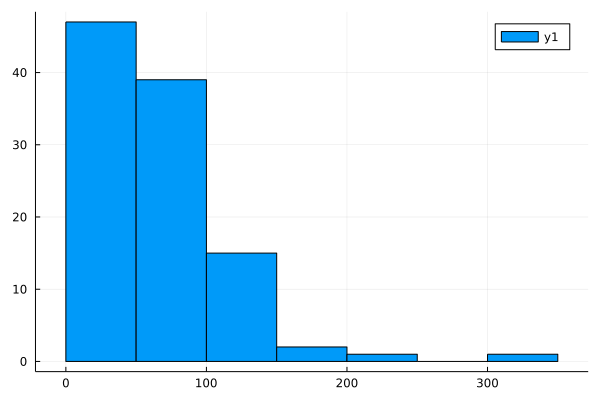

In [176]:
plot(last(diff_party_cosponsorship_samples), seriestype=:histogram)

# Ranking?

## Ranking top subject by number of different cosponsors

In [119]:
df = legislation
df = groupby(legislation, :SubjectsTopTerm)
df = sort(combine(df, 
        nrow => :Count, 
        :NumCosponsors => mean => :MeanCosponsors,
        :NumDifferentPartyCosponsored => mean => :MeanDifferentPartyCosponsored
        ), [:Count], rev=true) 
filter!(x -> x.Count >= 100, df)

println()
for r in eachrow(df)
    println("$(r.SubjectsTopTerm) & $(r.Count) & $(@sprintf("%.1f", r.MeanCosponsors)) & $(@sprintf("%.1f", r.MeanDifferentPartyCosponsored)) & $(@sprintf("%.2f", r.MeanCosponsors/r.MeanDifferentPartyCosponsored)) \\\\")
end


Health & 4476 & 7.4 & 2.6 & 2.81 \\
Foreign trade and international finance & 4002 & 1.1 & 0.4 & 2.44 \\
Taxation & 3849 & 5.6 & 2.0 & 2.83 \\
Armed forces and national security & 2835 & 5.4 & 1.8 & 2.92 \\
Public lands and natural resources & 2682 & 2.5 & 0.8 & 3.11 \\
Crime and law enforcement & 2080 & 6.4 & 1.9 & 3.42 \\
Government operations and politics & 1968 & 5.2 & 1.5 & 3.41 \\
Transportation and public works & 1446 & 3.9 & 1.4 & 2.77 \\
International affairs & 1293 & 7.8 & 2.9 & 2.68 \\
Energy & 1264 & 3.5 & 1.0 & 3.34 \\
Environmental protection & 1205 & 5.1 & 1.5 & 3.40 \\
Education & 1204 & 4.9 & 1.1 & 4.51 \\
Agriculture and food & 1096 & 4.4 & 1.5 & 2.85 \\
Finance and financial sector & 1085 & 6.0 & 2.1 & 2.80 \\
Labor and employment & 1024 & 7.5 & 1.1 & 7.12 \\
Commerce & 943 & 4.1 & 1.5 & 2.75 \\
Science, technology, communications & 806 & 4.8 & 1.8 & 2.66 \\
Private legislation & 776 & 0.3 & 0.1 & 3.81 \\
Immigration & 765 & 5.6 & 1.5 & 3.64 \\
Water resources devel

In [117]:
df = legislation

df = combine(
    df,
    nrow => :num_bills,
    :NumCosponsors => mean => :avg_cosponsors,
    :NumDifferentPartyCosponsored => mean => :avg_diff_party_cosponsors
)

r = df[1, :]
println("$(r.num_bills) & $(@sprintf("%.2f", r.avg_cosponsors)) & $(@sprintf("%.2f", r.avg_diff_party_cosponsors)) & $(@sprintf("%.2f", r.avg_cosponsors/r.avg_diff_party_cosponsors)) \\\\")


42933 & 4.90 & 1.61 & 3.04 \\


In [125]:
# Not sure about this, but it might make sense to ignore bills that didn't attract any cosponsorships at all
# These are the only bills that contribute to the cosponsorship network
# 13449/42933 don't have any cosponsors
df = filter(x->x.AnyCosponsored > 0, legislation)
df = groupby(legislation, :SubjectsTopTerm)
df = combine(df, :NumDifferentPartyCosponsored => mean => :MeanDifferentPartyCosponsored, nrow => :Count)
sort(df, :MeanDifferentPartyCosponsored, rev=true)

131×3 DataFrame
 Row │ SubjectsTopTerm           MeanDifferentPartyCosponsored  Count 
     │ String                    Float64                        Int64 
─────┼────────────────────────────────────────────────────────────────
   1 │ Money                                        10.5333        45
   2 │ Anniversaries                                 6.5            2
   3 │ Government paperwork                          6.44444        9
   4 │ Real property                                 6.2           10
   5 │ Securities                                    5.90909       22
   6 │ Gambling                                      5.33333        3
   7 │ Arts, culture, religion                       5.30337       89
   8 │ Disabled                                      5.04167       24
   9 │ Women                                         5.0            4
  10 │ Special days                                  5.0            1
  11 │ Awards, medals, prizes                        4.875          8
  ⋮  │            ⋮                            ⋮                  ⋮
 122 │ Private legislation                           0.0824742    776
 123 │ Public works                                  0.0            5
 124 │ Calendar                                      0.0            2
 125 │ Government corporations                       0.0            2
 126 │ Travel                                        0.0            1
 127 │ House of Representatives                      0.0            1
 128 │ Government liability                          0.0            3
 129 │ Legal services                                0.0            4
 130 │ Birth control                                 0.0            1
 131 │ Infrastructure                                0.0            1
                                                      110 rows omitted

In [159]:
df = filter(x->x.AnyCosponsored > 0, legislation)

df_earlier = filter(x->x.Congress in ["103", "104", "105"], df)
count_earlier = nrow(df_earlier)
df_later = filter(x->x.Congress in ["113", "114", "115"], df)
count_later = nrow(df_later)

df_earlier = combine(groupby(df_earlier, :SubjectsTopTerm), nrow => :CountEarlier)
df_later = combine(groupby(df_later, :SubjectsTopTerm), nrow => :CountLater)
evl = outerjoin(df_earlier, df_later, on=:SubjectsTopTerm)
evl.CountEarlier = coalesce.(evl.CountEarlier, 0)
evl.CountLater = coalesce.(evl.CountLater, 0)


df = transform(evl, [:CountEarlier, :CountLater] => ByRow((e, l) -> l-e) => :Diff)

# @df df plot(
#     :SubjectsTopTerm,
#     :Diff,
#     seriestype=:bar,
#     xrotation=90
# )
sort(df, :Diff, rev=true)

124×4 DataFrame
 Row │ SubjectsTopTerm                    CountEarlier  CountLater  Diff  
     │ String                             Int64         Int64       Int64 
─────┼────────────────────────────────────────────────────────────────────
   1 │ Health                                      411        1043    632
   2 │ Armed forces and national securi…           226         708    482
   3 │ Taxation                                    287         736    449
   4 │ Public lands and natural resourc…           169         566    397
   5 │ Education                                    59         440    381
   6 │ Government operations and politi…           185         546    361
   7 │ Crime and law enforcement                   209         504    295
   8 │ Finance and financial sector                 70         335    265
   9 │ International affairs                       105         350    245
  10 │ Energy                                       62         286    224
  11 │ Transportation and public works             124         313    189
  ⋮  │                 ⋮                       ⋮            ⋮         ⋮
 115 │ Roads and highways                           31           0    -31
 116 │ Parks                                        33           0    -33
 117 │ Federal budgets                              39           0    -39
 118 │ Money                                        42           0    -42
 119 │ Historic sites                               47           0    -47
 120 │ Private legislation                          54           2    -52
 121 │ Federal employees                            55           0    -55
 122 │ Commemorations                               66           0    -66
 123 │ Foreign trade and international …           191         101    -90
 124 │ Income tax                                  225           0   -225
                                                          103 rows omitted

In [179]:
df = filter(x->x.AnyCosponsored > 0, legislation)

df_earlier = filter(x->x.Congress in ["103", "104", "105"], df)
count_earlier = nrow(df_earlier)
println("Count earlier: $count_earlier")
df_later = filter(x->x.Congress in ["113", "114", "115"], df)
count_later = nrow(df_later)
println("Count later: $count_later")


df_earlier = combine(groupby(df_earlier, :SubjectsTopTerm), nrow => :CountEarlier)
df_later = combine(groupby(df_later, :SubjectsTopTerm), nrow => :CountLater)
evl = outerjoin(df_earlier, df_later, on=:SubjectsTopTerm)
evl.CountEarlier = coalesce.(evl.CountEarlier, 0)
evl.CountLater = coalesce.(evl.CountLater, 0)

df = transform(evl, [:CountEarlier, :CountLater] => ByRow((e, l) -> l-e) => :Diff)

df = transform(df, [:CountEarlier, :CountLater] => ByRow((e, l) -> (l/count_later)/(e/count_earlier)) => :ProportionalDiff)

# @df df plot(
#     :SubjectsTopTerm,
#     :Diff,
#     seriestype=:bar,
#     xrotation=90
# )
df = sort(df, :ProportionalDiff, rev=true)

more_represented = first(df, 23)
less_represented = last(df, 101)

Count earlier: 4615
Count later: 8131


101×5 DataFrame
 Row │ SubjectsTopTerm                    CountEarlier  CountLater  Diff   Pro ⋯
     │ String                             Int64         Int64       Int64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Labor and employment                        155         248     93      ⋯
   2 │ Environmental protection                    173         264     91
   3 │ Sports and recreation                        11          12      1
   4 │ Water resources development                  76          77      1
   5 │ Social welfare                               95          94     -1      ⋯
   6 │ Law                                          83          82     -1
   7 │ Agriculture and food                        169         147    -22
   8 │ Families                                     52          37    -15
   9 │ Arts, culture, religion                      26          18     -8      ⋯
  10 │ Foreign trade and international …           191         101    -90
  11 │ Private legislation                          54           2    -52
  12 │ Fisheries                                    22           0    -22
  13 │ Holidays                                      1           0     -1      ⋯
  14 │ Space sciences                                7           0     -7
  15 │ Income tax                                  225           0   -225
  16 │ Roads and highways                           31           0    -31
  17 │ Federal officials                            16           0    -16      ⋯
  18 │ Monuments and memorials                      15           0    -15
  19 │ Recreation                                   19           0    -19
  20 │ Government property                           2           0     -2
  21 │ Domestic relations                            7           0     -7      ⋯
  22 │ Federal employees                            55           0    -55
  23 │ Wilderness areas                             12           0    -12
  24 │ Antitrust law                                14           0    -14
  25 │ Drugs                                        18           0    -18      ⋯
  26 │ Marine transportation                        11           0    -11
  27 │ Mines and mineral resources                  10           0    -10
  28 │ Railroads                                    10           0    -10
  29 │ Firearms                                     25           0    -25      ⋯
  30 │ Federal incorporation                         4           0     -4
  31 │ Forests and forestry                         24           0    -24
  32 │ Public works                                  2           0     -2
  33 │ Nuclear energy                               16           0    -16      ⋯
  34 │ Criminal procedure                           21           0    -21
  35 │ Motor vehicles                                8           0     -8
  36 │ Money                                        42           0    -42
  37 │ Intergovernmental relations                  12           0    -12      ⋯
  38 │ Statistics                                    7           0     -7
  39 │ Consumer protection                          14           0    -14
  40 │ Corrections                                  17           0    -17
  41 │ Small business                               20           0    -20      ⋯
  42 │ Arms control                                  8           0     -8
  43 │ Copyright                                    14           0    -14
  44 │ Government paperwork                          8           0     -8
  45 │ Federal budgets                              39           0    -39      ⋯
  46 │ Securities                                   15           0    -15
  47 │ Ships                                         5           0     -5
  48 │ Historic sites                               47           0    -47
  49 │ Disasters                                     9           0     -9      ⋯
  50 │ Unemployment insu

In [186]:
more_represented_subjects = more_represented.SubjectsTopTerm
less_represented_subjects = less_represented.SubjectsTopTerm

leg_from_more_represented = filter(x->x.SubjectsTopTerm in more_represented_subjects, legislation)
sum(leg_from_more_represented.NumDifferentPartyCosponsored)/nrow(leg_from_more_represented)

leg_from_less_represented = filter(x->x.SubjectsTopTerm in less_represented_subjects, legislation)
sum(leg_from_less_represented.NumDifferentPartyCosponsored)/nrow(leg_from_less_represented)

combine(groupby(leg_from_more_represented, :SubjectsTopTerm), (rows) -> sum(rows.NumDifferentPartyCosponsored)/nrow(rows))

23×2 DataFrame
 Row │ SubjectsTopTerm                    x1       
     │ String                             Float64  
─────┼─────────────────────────────────────────────
   1 │ Health                             2.64254
   2 │ Armed forces and national securi…  1.83351
   3 │ Crime and law enforcement          1.88173
   4 │ Economics and public finance       0.801282
   5 │ Government operations and politi…  1.51321
   6 │ Transportation and public works    1.42254
   7 │ Congress                           1.22348
   8 │ Education                          1.08472
   9 │ Public lands and natural resourc…  0.801268
  10 │ Taxation                           1.99299
  11 │ International affairs              2.90642
  12 │ Immigration                        1.53725
  13 │ Native Americans                   0.790808
  14 │ Civil rights and liberties, mino…  2.27488
  15 │ Housing and community development  1.31308
  16 │ Finance and financial sector       2.14654
  17 │ Energy                             1.04509
  18 │ Commerce                           1.48144
  19 │ Science, technology, communicati…  1.82258
  20 │ Animals                            3.65278
  21 │ Emergency management               1.38129
  22 │ Social sciences and history        0.933333
  23 │                                    0.111111

# Matching?

## Matching by stuff

## Thresholded

In [122]:
# Filter to (legislation introduced by D or R) and (legislation with any cosponsor)
#filtered_legislation = filter(row -> row.AnyCosponsored == 1 && is_main_party(row.SponsorParty), legislation)
filtered_legislation = filter(row -> is_main_party(row.SponsorParty), legislation)
#thresholds = map(x -> x*10, 1:30)
mean_num_subjects = mean(filtered_legislation.NumSubjects)
median_num_subjects = median(filtered_legislation.NumSubjects)
std_num_subjects = std(filtered_legislation.NumSubjects)
mad_num_subjects = mad(filtered_legislation.NumSubjects, normalize=false)
lower_quartile_num_subjects = percentile(filtered_legislation.NumSubjects, 25)
upper_quartile_num_subjects = percentile(filtered_legislation.NumSubjects, 75)
mean_size = mean(filtered_legislation.Size)
median_size = median(filtered_legislation.Size)
std_size = std(filtered_legislation.Size)
mad_size = mad(filtered_legislation.Size, normalize=false)
lower_quartile_size = percentile(filtered_legislation.Size, 25)
upper_quartile_size = percentile(filtered_legislation.Size, 75)

function is_complex(size)
    complex = if (size > upper_quartile_size)
        true
    else
        false
    end
    not_complex = if (size < lower_quartile_size)
        true
    else
        false
    end
    
    if (complex && not_complex)
        error("Found row that was both complex and not complex")
    end
    
    return if (complex)
        1
    elseif (not_complex)
        0
    else
        -1
    end
end

# Assumes each group has both a complex and non-complex
function generate_pairs(comparable_groups)
    function choose_from_group(group)
        n = nrow(group)
        return group[rand(1:n), :]
    end
    
    pairs = []
    for (not_complex, complex) in comparable_groups
        push!(pairs, (choose_from_group(not_complex), choose_from_group(complex)))
    end
    
    return pairs
end

# Add complexity column
df = transform(filtered_legislation, [:Size] => ByRow((size) -> is_complex(size)) => :Complex)
# Remove "medium" complexity
df = filter(row -> row.Complex >= 0, df)
# Group by congress, type (s, etc), subjects top term, and sponsor
df = groupby(df, [:Congress, :Type, :SubjectsTopTerm, :SponsorId])
# Filter to groups with both complex and not complex bills
df = filter(group -> nrow(unique(group, :Complex)) > 1, df)
comparable_groups = []
for group in df
    complex_grouped = groupby(group, [:Complex])
    not_complex = complex_grouped[(Complex=0,)]
    complex = complex_grouped[(Complex=1,)]
    
    push!(comparable_groups, (not_complex, complex))
end

avg_differences = []
complex_samples = []
not_complex_samples = []
difference_samples = []
for i in 1:30
    pairs = generate_pairs(comparable_groups)
    differences = [complex.NumDifferentPartyCosponsored - not_complex.NumDifferentPartyCosponsored for (not_complex, complex) in pairs]
    
    push!(avg_differences, mean(differences))
    append!(complex_samples, [complex.NumDifferentPartyCosponsored for (_, complex) in pairs])
    append!(not_complex_samples, [not_complex.NumDifferentPartyCosponsored for (not_complex, _) in pairs])
    append!(difference_samples, differences)
end

println(mean(avg_differences))

0.4094594594594595


## Continuous

In [131]:
filtered_legislation = filter(row -> is_main_party(row.SponsorParty), legislation)
df = filter(row -> row.AnyCosponsored == 1, filtered_legislation)

# Group by congress, type (s, etc), subjects top term, and sponsor
df = groupby(filtered_legislation, [:Congress, :Type, :SubjectsTopTerm, :SponsorId])
# Filter to groups with multiple bills
df = filter(group -> nrow(group) > 1, df)


row_pairs = []
for group in df
    rows = collect(zip(group.Size, group.NumDifferentPartyCosponsored))
    for (r1, r2) in combinations(rows, 2)
        if (r1[1] > r2[1])
            push!(row_pairs, (r1, r2))
        elseif (r2[1] > r1[1])
            push!(row_pairs, (r2, r1))
        # Note: not adding pairs where size is ==
        end
    end
end

println(length(row_pairs))

function build_empirical_diff_dists()
    size_diff::Vector{Int32} = []
    num_different_party_cosponsored_diff::Vector{Int32} = []
    for pair in row_pairs
        push!(size_diff, pair[1][1] - pair[2][1])
        push!(num_different_party_cosponsored_diff, pair[1][2] - pair[2][2])
    end
    return DataFrame(SizeDiff=size_diff, NumDifferentPartyCosponsoredDiff=num_different_party_cosponsored_diff)
end

function build_empirical_dists()
    return 
end

df = build_empirical_diff_dists()

143415


143415×2 DataFrame
    Row │ SizeDiff  NumDifferentPartyCosponsoredDiff 
        │ Int32     Int32                            
────────┼────────────────────────────────────────────
      1 │      866                                 1
      2 │   256411                               -11
      3 │   174316                                 1
      4 │   264752                                 4
      5 │   283744                                -1
      6 │   217996                                 2
      7 │   285685                                 2
      8 │   285632                                 3
      9 │  1159923                                -4
     10 │   284725                                 3
     11 │   120386                                 3
     12 │   849465                                -4
     13 │   286147                                 0
     14 │   290728                                 4
     15 │   260403                                 3
     16 │   289246                                 3
     17 │   237964                                 4
     18 │   292533                                 3
     19 │   285788                                 3
     20 │   286292                                 4
     21 │   273363                                 4
     22 │   280991                                -2
     23 │   236802                                -6
     24 │    82095                               -12
     25 │     8341                                15
     26 │    27333                                10
     27 │    38415                               -13
     28 │    29274                                13
     29 │    29221                                14
     30 │  1416334                               -15
     31 │    28314                                14
     32 │   136025                               -14
     33 │  1105876                               -15
     34 │    29736                                11
     35 │    34317                                15
     36 │     3992                                14
     37 │    32835                                14
     38 │    18447                               -15
     39 │    36122                                14
     40 │    29377                                14
     41 │    29881                                15
     42 │    16952                                15
     43 │    24580                                 9
     44 │    19609                                -5
     45 │    90436                                 3
     46 │   109428                                -2
     47 │    43680                                 1
     48 │   111369                                 1
     49 │   111316                                 2
     50 │  1334239                                -3
     51 │   110409                                 2
     52 │    53930                                -2
     53 │  1023781                                -3
     54 │   111831                                -1
     55 │   116412                                 3
     56 │    86087                                 2
     57 │   114930                                 2
     58 │    63648                                 3
     59 │   118217                                 2
     60 │   111472                                 2
     61 │   111976                                 3
     62 │    99047                                 3
     63 │   106675                                -3
     64 │    62486                                -7
     65 │    18992                                -5
     66 │    46756                                 2
     67 │    20933                                -2
     68 │    20880                                -1
     69 │  1424675                                 0
     70 │    19973                                -1
     71 │   144366                                 1
     72 │  1114217                                 0
   

In [133]:
lm1 = fit(LinearModel, @formula(NumDifferentPartyCosponsoredDiff ~ SizeDiff), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

NumDifferentPartyCosponsoredDiff ~ 1 + SizeDiff

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)   0.133619    0.0111414   11.99    <1e-32   0.111782     0.155456
SizeDiff     -3.99933e-7  1.04405e-7  -3.83    0.0001  -6.04565e-7  -1.95301e-7
───────────────────────────────────────────────────────────────────────────────

In [134]:
r2(lm1)

0.00010230525275589653

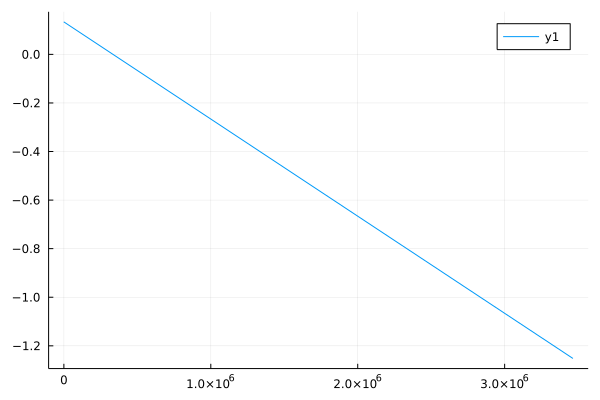

In [15]:
plot(df.SizeDiff, predict(lm), seriestype = :line)

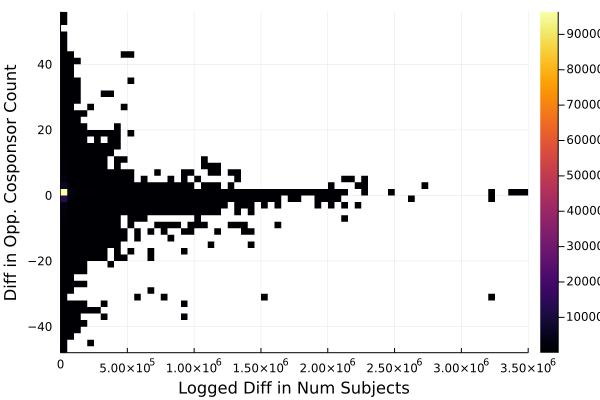

In [132]:
@df df plot(
    #log.(:SizeDiff),
    :SizeDiff,
    :NumDifferentPartyCosponsoredDiff,
    seriestype=:histogram2d,
    bins=70,
    #xtickfontsize = 12,
    #ytickfontsize = 12,
    xlabel="Logged Diff in Num Subjects",
    ylabel="Diff in Opp. Cosponsor Count"
)
#savefig("$PAPER_FIGURES_PATH/subjects_bicosponsors_joint.png")

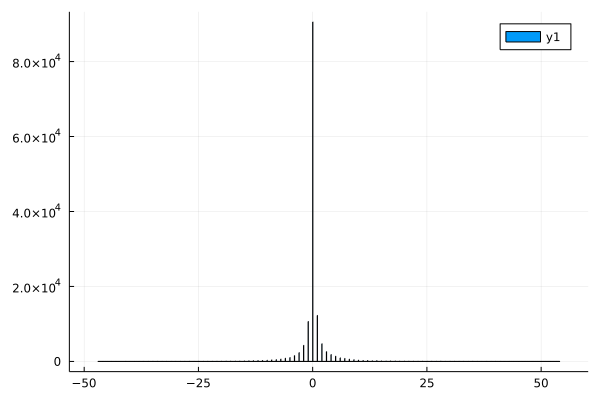

In [17]:
@df df plot(
    :NumDifferentPartyCosponsoredDiff,
    seriestype=:histogram
)

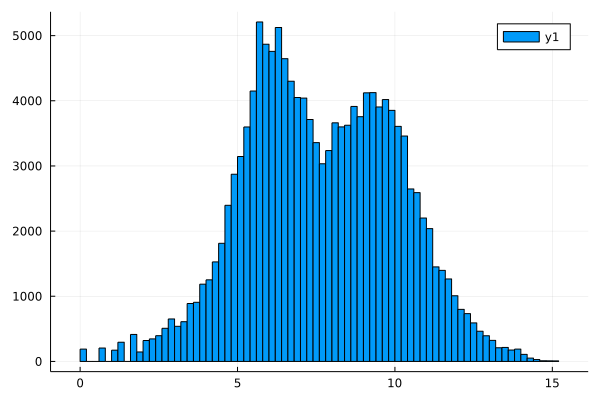

In [20]:
@df df plot(
    log.(:SizeDiff),
    seriestype=:histogram
)

## Better Thresholded

In [123]:
function is_complex(size)
    return if (size > upper_quartile_size)
        true
    else
        false
    end
end

function is_not_complex(size)
    return if (size < lower_quartile_size)
        true
    else
        false
    end
end

filtered_legislation = filter(row -> is_main_party(row.SponsorParty), legislation)

# Group by congress, type (s, etc), subjects top term, and sponsor
df = groupby(filtered_legislation, [:Congress, :Type, :SubjectsTopTerm, :SponsorId])
# Filter to groups with both complex and not complex bills
df = filter(group -> nrow(group) > 1, df)


row_pairs = []
for group in df
    rows = collect(zip(group.Size, group.NumDifferentPartyCosponsored))
    for (r1, r2) in combinations(rows, 2)
        if (r1[1] > r2[1])
            push!(row_pairs, (r1, r2))
        elseif (r2[1] > r1[1])
            push!(row_pairs, (r2, r1))
        # Note: not adding pairs where size is ==
        end
    end
end

filter!(x -> is_complex(x[1][1]) && is_not_complex(x[2][1]), row_pairs)

function build_empirical_diff_dists()
    size_diff::Vector{Int32} = []
    num_different_party_cosponsored_diff::Vector{Int32} = []
    for pair in row_pairs
        push!(size_diff, pair[1][1] - pair[2][1])
        push!(num_different_party_cosponsored_diff, pair[1][2] - pair[2][2])
    end
    return DataFrame(SizeDiff=size_diff, NumDifferentPartyCosponsoredDiff=num_different_party_cosponsored_diff)
end

function build_empirical_dists()
    return 
end

df = build_empirical_diff_dists()

7894×2 DataFrame
  Row │ SizeDiff  NumDifferentPartyCosponsoredDiff 
      │ Int32     Int32                            
──────┼────────────────────────────────────────────
    1 │   292533                                 3
    2 │    36122                                14
    3 │   118217                                 2
    4 │    27781                                -1
    5 │    74537                                 1
    6 │  1452456                                -1
    7 │   172147                                 0
    8 │  1141998                                -1
    9 │    32130                                 0
   10 │    54569                                -1
   11 │    19170                                -1
   12 │    55731                                 9
   13 │    89686                                 1
   14 │    89002                                 1
   15 │    89414                                 1
   16 │    88841                                 1
   17 │    89611                                 1
   18 │    88807                                 1
   19 │    88608                                 1
   20 │    88875                                 1
   21 │    88960                                 1
   22 │    89480                                 1
   23 │    67874                                 2
   24 │    30236                                 0
   25 │    52865                                 0
   26 │    31541                                14
   27 │    17829                                 2
   28 │    61756                                 1
   29 │    67190                                 2
   30 │    67602                                 2
   31 │    67029                                 2
   32 │    67799                                 2
   33 │    66995                                 2
   34 │    66796                                 2
   35 │    67063                                 2
   36 │    67148                                 2
   37 │    67668                                 2
   38 │    29552                                 0
   39 │    29964                                 0
   40 │    29391                                 0
   41 │    30161                                 0
   42 │    29357                                 0
   43 │    29158                                 0
   44 │    29425                                 0
   45 │    29510                                 0
   46 │    30030                                 0
   47 │    52181                                 0
   48 │    52593                                 0
   49 │    52020                                 0
   50 │    52790                                 0
   51 │    51986                                 0
   52 │    51787                                 0
   53 │    52054                                 0
   54 │    52139                                 0
   55 │    52659                                 0
   56 │    30857                                14
   57 │    17145                                 2
   58 │    61072                                 1
   59 │    31269                                14
   60 │    17557                                 2
   61 │    61484                                 1
   62 │    30696                                14
   63 │    31466                                14
   64 │    30662                                14
   65 │    30463                                14
   66 │    30730                                14
   67 │    30815                                14
   68 │    31335                                14
   69 │    16984                                 2
   70 │    60911                                 1
   71 │    17754                                 2
   72 │    16950                                 2
   73 │    16751                                 2
   74 │    17018                                 2
   75 │    17103                                 2
  

In [124]:
mean(df.NumDifferentPartyCosponsoredDiff)

0.46757030656194576

In [125]:
std(df.NumDifferentPartyCosponsoredDiff)

5.156135562732475

# Modularity

In [26]:
df = innerjoin(legislation_cosponsor, legislation, on=[:LegislationId => :Id], makeunique=true)
df = innerjoin(df, legislators, on=[:SponsorId => :BioguideId], renamecols = "" => "_sponsor")
df = leftjoin(df, legislators, on=[:CosponsorId => :BioguideId], renamecols = "" => "_cosponsor", matchmissing=:notequal)

df = groupby(df, [:Congress])

GroupedDataFrame with 13 groups based on key: Congress
First Group (13887 rows): Congress = 103
   Row │ LegislationId  SponsorId  CosponsorId  Congress  Type     Number  Siz ⋯
       │ String15       String7    String7?     Int64     String1  Int64   Int ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ s1766-103      G000352    M000019           103  s          1766    5 ⋯
     2 │ s1886-103      W000154    R000295           103  s          1886    2
     3 │ s1-103         K000105    B000711           103  s             1  294
     4 │ s1-103         K000105    D000388           103  s             1  294
     5 │ s1-103         K000105    D000566           103  s             1  294 ⋯
     6 │ s1-103         K000105    H000206           103  s             1  294
     7 │ s1-103         K000105    H000338           103  s             1  294
     8 │ s1-103         K000105    I000025           103  s             1  294
     9 │ s1-103         K000105    K000017           103  s             1  294 ⋯
    10 │ s1-103         K000105    K000148           103  s             1  294
    11 │ s1-103         K000105    L000123           103  s             1  294
    12 │ s1-103         K000105    L000174           103  s             1  294
    13 │ s1-103         K000105    L000261           103  s             1  294 ⋯
    14 │ s1-103         K000105    M000678           103  s             1  294
    15 │ s1-103         K000105    M000702           103  s             1  294
    16 │ s1-103         K000105    M001025           103  s             1  294
    17 │ s1-103         K000105    P000193           103  s             1  294 ⋯
    18 │ s1-103         K000105    R000249           103  s             1  294
    19 │ s1-103         K000105    R000361           103  s             1  294
    20 │ s1-103         K000105    S000064           103  s             1  294
    21 │ s1-103         K000105    S000423           103  s             1  294 ⋯
    22 │ s1-103         K000105    W000288           103  s             1  294
    23 │ s1-103         K000105    W000665           103  s             1  294
    24 │ s519-103       B001057    B000993           103  s           519    2
    25 │ s519-103       B001057    C000705           103  s           519    2 ⋯
    26 │ s519-103       B001057    D000064           103  s           519    2
    27 │ s519-103       B001057    D000185           103  s           519    2
    28 │ s519-103       B001057    D000432           103  s           519    2
    29 │ s519-103       B001057    F000061           103  s           519    2 ⋯
    30 │ s519-103       B001057    H000206           103  s           519    2
    31 │ s519-103       B001057    J000072           103  s           519    2
    32 │ s519-103       B001057    K000305           103  s           519    2
    33 │ s519-103       B001057    L000123           103  s           519    2 ⋯
    34 │ s519-103       B001057    S000068           103  s           519    2
    35 │ s519-103       B001057    W000665           103  s           519    2
    36 │ s2243-103      S000888    C000858           103  s          2243    9
    37 │ s2243-103      S000888    G000333           103  s          2243    9 ⋯
    38 │ s2243-103      S000888    H000343           103  s          2243    9
    39 │ s2243-103      S000888    M001085           103  s          2243    9
    40 │ s2243-103      S000888    M001111           103  s          2243    9
    41 │ s2243-103      S000888    P000009           103  s          2243    9 ⋯
    42 │ s788-103       I000025    A000069           103  s           788    1
    43 │ s2489-103      K000105    A000069           103  s          2489   38
    44 │ s2489-103      K000105    B000444           103  s          2489   38
    45 │ s2489-103      K000105    B000468           103  s          2489   38 ⋯
    46 │ s2489-103      K000105    B000639           103  s          2489   38
   

In [44]:
function party_to_number(party)
    return if (party == "Republican") 
        0
    else
        1
    end
end

function build_graph(congress)
    filtered_congress = dropmissing(congress)
    l = collect(union(Set(filtered_congress.SponsorId), Set(filtered_congress.CosponsorId)))
    sort!(l)
    
    d = Dict(i => n for (n, i) in enumerate(l))
    num_nodes = length(l)
    g = zeros(Int8, num_nodes, num_nodes)
    s = zeros(Int8, num_nodes)
    
    for (sponsor, cosponsor, sponsor_party, cosponsor_party) in zip(filtered_congress.SponsorId, filtered_congress.CosponsorId, filtered_congress.Party_sponsor, filtered_congress.Party_cosponsor)
        i = d[sponsor]; j = d[cosponsor]
        g[i, j] += 1
        g[j, i] += 1
        s[i] = party_to_number(sponsor_party)
        s[j] = party_to_number(cosponsor_party)
    end
    
    return (g, s, d)
end

function calculate_modularity(g, s)
    two_m = sum(g)
    num_nodes = size(g, 1)
    acc = 0
    for i in 1:num_nodes
        for j in 1:num_nodes
            expected = (sum(g[i, :]) * sum(g[j, :])) / two_m
            acc += (g[i, j] - expected) * (s[i] == s[j])
        end
    end
            
    return (1 / two_m) * acc
end

calculate_modularity (generic function with 1 method)

In [40]:
congresses = 103:115
modularities = []
for congress in congresses
    g, s, _ = build_graph(df[(Congress=congress,)])
    push!(modularities, calculate_modularity(g, s))
end

(Int8[0 1 … 5 1; 1 0 … 2 1; … ; 5 2 … 0 11; 1 1 … 11 0], Int8[1, 0, 1, 0, 1, 0, 1, 1, 0, 0  …  1, 1, 1, 0, 0, 0, 1, 1, 1, 1], Dict{String7, Int64}("W000802" => 107, "N000180" => 83, "P000590" => 84, "W000779" => 106, "B000953" => 9, "H000206" => 47, "K000374" => 63, "B000382" => 4, "L000035" => 64, "S001163" => 97…))

In [79]:
function build_cross_party_cosponsorship_matrix(g, s)
    two_m = sum(g)
    num_nodes = size(g, 1)
    acc = 0

    h = zeros(Float64, num_nodes, num_nodes)
    for i in 1:num_nodes
        for j in 1:num_nodes
            expected = (sum(g[i, :]) * sum(g[j, :])) / two_m
            # Note using not-equals
            h[i, j] = (g[i, j] - expected) * (s[i] != s[j])
        end
    end

    return h
end

build_cross_party_cosponsorship_matrix (generic function with 1 method)

In [81]:
g_111, s_111, d_111 = build_graph(df[(Congress=111,)])
h_111 = build_cross_party_cosponsorship_matrix(g_111, s_111)

109×109 Matrix{Float64}:
 -0.0        -1.07429      0.0        …  -0.0         0.0        -0.0
 -1.07429    -0.0          0.222035      -2.03943     0.766755    0.511931
  0.0         0.222035    -0.0           -0.0        -0.0        -0.0
 -0.816794    0.0         -1.55725       -1.78626    -1.08015    -0.427481
  0.0        -2.54057     -0.0            0.0        -0.0         0.0
 -0.331791    0.0          1.00132    …  -2.2926     -1.38634    -0.548657
 -0.0        -1.57108     -0.0            0.0         0.0        -0.0
 -0.0        -2.58415     -0.0            0.0         0.0        -0.0
 -2.4633      0.0          0.17431       -1.38829    -0.653603   -0.0501893
 -1.04568     0.0          2.24656       -1.0113     -0.216235   -0.481337
  5.49378     0.0          0.137525   …  -4.43049     1.32088    -0.0602873
  0.0         0.694957    -0.0           -0.0         0.0         0.0
 -0.0        -1.43806     -0.0            0.0         0.0         0.0
 -1.70235    -0.0          0.5408

In [82]:
g_112, s_112, d_112 = build_graph(df[(Congress=112,)])
h_112 = build_cross_party_cosponsorship_matrix(g_112, s_112)

101×101 Matrix{Float64}:
 -0.0       -0.987019  -0.747512   …   0.0         0.0       -0.0
 -0.987019  -0.0       -0.0           -3.28559    -0.398529  -0.720035
 -0.747512  -0.0       -0.0           -3.76902     0.770044  -0.633245
  0.0       -2.31934   -2.03978       -0.0        -0.0       -0.0
  0.0       -0.409347  -2.11893       -0.0         0.0       -0.0
 -3.1402     0.0        0.0        …  -4.77276    -2.21017   -1.13791
 -0.0       -2.33016   -0.928757       0.0        -0.0        0.0
 -0.0       -2.19862   -2.81307        0.0         0.0       -0.0
 -2.32648    0.0        0.0           -7.17454    -1.34129   -0.205415
 -0.987019  -0.0       -0.0           -3.28559    -0.398529  -0.720035
  0.779965   0.0       -0.0        …  -6.94495    -2.26637   -1.16684
  0.0       -2.39939    1.01035        0.0         0.0       -0.0
  0.0        2.48377   -0.333467      -0.0         0.0        0.0
 -1.85634   -0.0        0.0           -2.16054     0.989615  -0.0350498
  0.0       -1.96

109


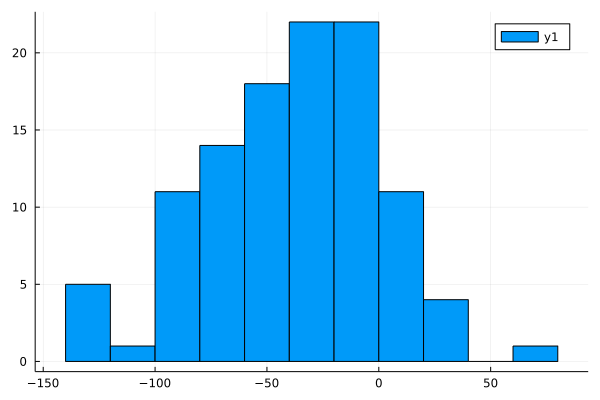

In [98]:
println(length(s_111))
plot(
    sum(h_111, dims=2),
    seriestype=:histogram
)

54


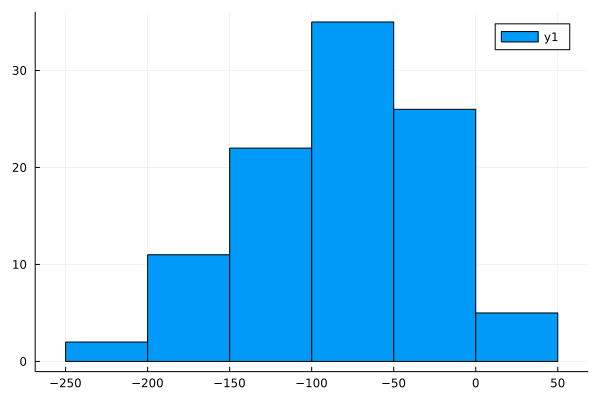

In [97]:
println(sum(s_112))
plot(
    sum(h_112, dims=2),
    seriestype=:histogram
)

In [91]:
for (i, j) in enumerate(sum(h_112, dims=2))
    println("$i $j")
end

1 -74.08978797057551
2 -59.3933362180874
3 -67.3146751560858
4 -49.50550163812821
5 -73.76392408975705
6 -92.80911170179883
7 -113.56163071026764
8 -137.87624405019469
9 -116.3147369722446
10 -51.3933362180874
11 -177.16866538913274
12 -52.60657105767449
13 -47.58419360820917
14 -42.75292081350065
15 -145.3705878716697
16 -55.26958026828212
17 -68.62907213945726
18 -20.22463992087532
19 -69.03378253075354
20 -65.58431724052669
21 -129.47202818816837
22 -27.168603572973982
23 -1.3594918711751245
24 -66.14616430734998
25 0.07850652160475136
26 -115.91021202942451
27 -122.39308895345243
28 -35.07869197008099
29 -73.77517463064844
30 -161.66273103789325
31 -202.97765345861407
32 -36.359584595413246
33 -95.96640291772272
34 -100.2470173703406
35 -154.92118439760154
36 -59.95512146875194
37 -19.011343265129504
38 -168.39302713729376
39 -115.15713667552701
40 -188.4608085553564
41 -103.40461766705818
42 -42.84277060023489
43 -25.68526302775546
44 -102.76414044631265
45 -175.92149347839518
46 

In [69]:
function key_for_value(d, value)
    for (k, v) in d
        if (v == value)
            return k
        end
    end
    error("Couldn't find")
end

key_for_value (generic function with 1 method)

In [93]:
key_for_value(d_112, 99)

"W000802"

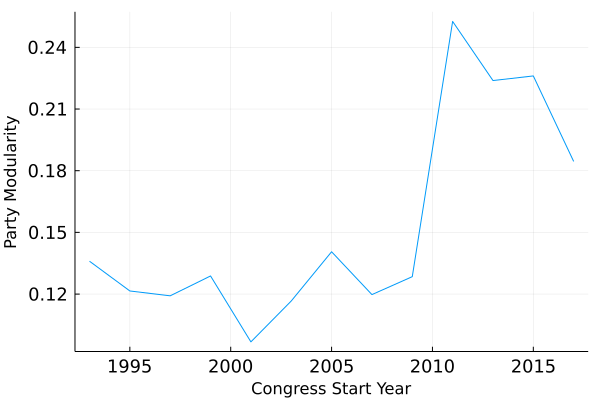

In [35]:
plot(
    map(x -> congress_to_start_year(x), congresses),
    modularities,
    xlabel="Congress Start Year",
    ylabel="Party Modularity",
    #xguidefontsize = 16,
    #yguidefontsize = 16,
    xtickfontsize = 12,
    ytickfontsize = 12,
    legend=false
)
#savefig("$FIGURES_PATH/PartyModularity.png")

In [ ]:
function build_metagraph(congress)
    filtered_congress = dropmissing(congress)
    l = collect(union(Set(filtered_congress.SponsorId), Set(filtered_congress.CosponsorId)))
    sort!(l)
    
    d = Dict(i => n for (n, i) in enumerate(l))
    num_nodes = length(l)
    g = zeros(Int8, num_nodes, num_nodes)
    s = zeros(Int8, num_nodes)
    
    for (sponsor, cosponsor, sponsor_party, cosponsor_party) in zip(filtered_congress.SponsorId, filtered_congress.CosponsorId, filtered_congress.Party_sponsor, filtered_congress.Party_cosponsor)
        i = d[sponsor]; j = d[cosponsor]
        g[i, j] += 1
        g[j, i] += 1
        s[i] = party_to_number(sponsor_party)
        s[j] = party_to_number(cosponsor_party)
    end
    
    return (g, s)
end

function build_bipartite_legislator_graph(congress)
    filtered_congress = dropmissing(congress)
    l = collect(union(Set(filtered_congress.SponsorId), Set(filtered_congress.CosponsorId)))
    sort!(l)
    
    d = Dict(i => n for (n, i) in enumerate(l))
    num_nodes = length(l)
    g = zeros(Int8, num_nodes, num_nodes)
    s = zeros(Int8, num_nodes)
    
    for (sponsor, cosponsor, sponsor_party, cosponsor_party) in zip(filtered_congress.SponsorId, filtered_congress.CosponsorId, filtered_congress.Party_sponsor, filtered_congress.Party_cosponsor)
        i = d[sponsor]; j = d[cosponsor]
        s[i] = party_to_number(sponsor_party)
        s[j] = party_to_number(cosponsor_party)
        
        if (s[i] != s[j])
            g[i, j] += 1
            g[j, i] += 1
        end
    end
    
    return (g, s)
end

congresses = 103:115
modularities = []
for congress in congresses
    g, s = build_graph(df[(Congress=congress,)])
    push!(modularities, calculate_modularity(g, s))
end

In [141]:
g = MetaGraph()
add_vertex!(g, Dict(:Name=>"Alex"))
add_vertex!(g, Dict(:Name=>"Not Alex"))
add_edge!(g, 1, 2)

true

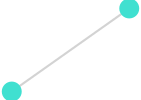

In [138]:
gplot(g)

In [75]:
collect(combinations([1], 2))

Vector{Int64}[]